In [56]:
from hepmc import *
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
eeqqg = densities.ee_qq_ng(1, 100., 5., .3)

In [3]:
rambo_mapping = phase_space.RamboOnDiet(100., 3)
mapped = phase_space.MappedDensity(eeqqg, rambo_mapping)

In [39]:
# adaptive Metropolis
def adapt_schedule(t):
    if t < 5000:
        return True
    else:
        return False
    
met = AdaptiveMetropolisUpdate(5, mapped, proposals.Gaussian(5, .01), t_initial=1000, adapt_schedule=adapt_schedule)
%time met_sample = met.sample(106000, np.random.rand(5))
met_sample.data = met_sample.data[6000:] # discard warmup samples

Event 1	(batch acceptance rate: 1.000000)
Event 2	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 3	(batch acceptance rate: 0.666667)	max sequence length: 2
Event 4	(batch acceptance rate: 0.750000)	max sequence length: 2
Event 5	(batch acceptance rate: 0.800000)	max sequence length: 2
Event 6	(batch acceptance rate: 0.833333)	max sequence length: 2
Event 7	(batch acceptance rate: 0.714286)	max sequence length: 2
Event 8	(batch acceptance rate: 0.625000)	max sequence length: 3
Event 9	(batch acceptance rate: 0.666667)	max sequence length: 3
Event 10	(batch acceptance rate: 0.600000)	max sequence length: 3
Event 20	(batch acceptance rate: 0.550000)	max sequence length: 4
Event 30	(batch acceptance rate: 0.533333)	max sequence length: 4
Event 40	(batch acceptance rate: 0.450000)	max sequence length: 7
Event 50	(batch acceptance rate: 0.380000)	max sequence length: 7
Event 60	(batch acceptance rate: 0.316667)	max sequence length: 17
Event 70	(batch acceptance rate: 0.314286

In [45]:
df = pd.DataFrame(met_sample.data[::100])

<IPython.core.display.Javascript object>


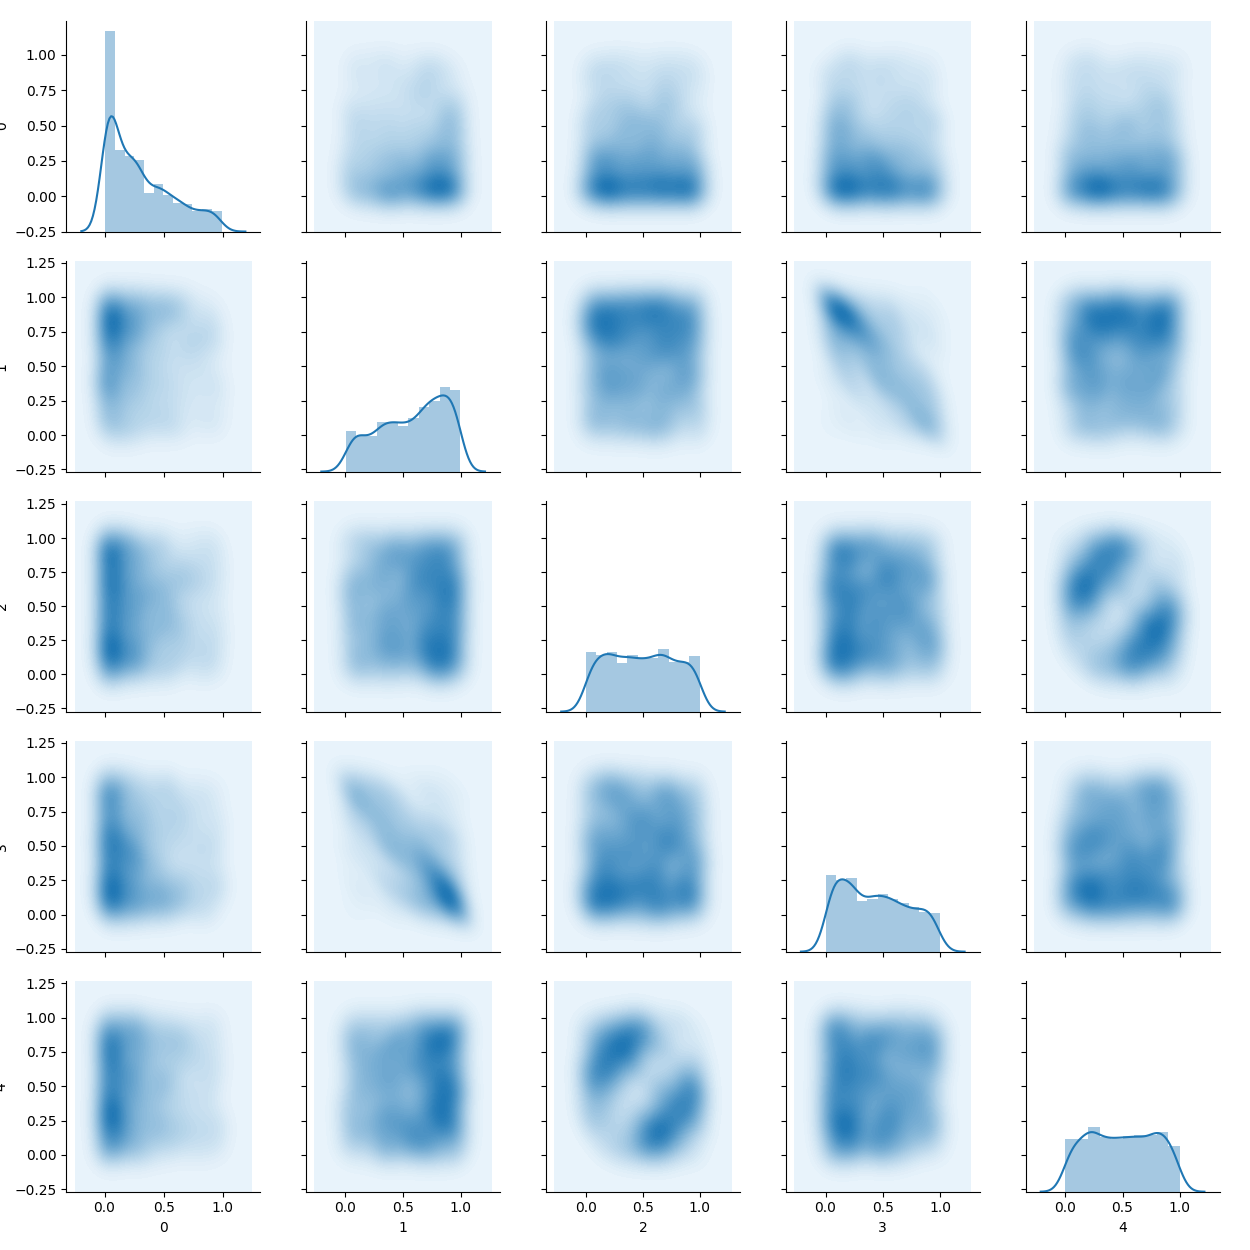

/net/theorie/home/tjansse2/studium/masterarbeit/hep-monte-carlo/hepmc_env/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [49]:
g = sns.PairGrid(df)
#g.map(sns.kdeplot)
g.map_upper(sns.kdeplot, n_levels=60, shade=True)
g.map_lower(sns.kdeplot, n_levels=60, shade=True)
g.map_diag(sns.distplot)
plt.show()

In [60]:
nodes = 100
nlearn = 1000

xvals = np.random.random((nlearn, 5))
fvals = mapped.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(5)
log_vals = -np.ma.log(fvals)
xvals = xvals[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]
# train
params = basis.extreme_learning_train(xvals, log_vals, nodes)

# surrogate
def surrogate_fn(xs):
    return basis.eval(*params, xs)[0]

In [59]:
xs = np.empty((1, 5))
xs[0] = np.array([.1, .2, .3, .4, .5])
surrogate_fn(xs)[0]

-4.14925683631758

In [61]:
# adaptive Metropolis
def adapt_schedule(t):
    if t < 5000:
        return True
    else:
        return False
    
met = AdaptiveMetropolisUpdate(5, surrogate_fn, proposals.Gaussian(5, .01), t_initial=1000, adapt_schedule=adapt_schedule)
%time met_sample = met.sample(106000, np.random.rand(5))
met_sample.data = met_sample.data[6000:] # discard warmup samples

Event 1	(batch acceptance rate: 1.000000)
Event 2	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 3	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 4	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 5	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 6	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 7	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 8	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 9	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 10	(batch acceptance rate: 1.000000)	max sequence length: 1
Event 20	(batch acceptance rate: 0.950000)	max sequence length: 2
Event 30	(batch acceptance rate: 0.966667)	max sequence length: 2
Event 40	(batch acceptance rate: 0.975000)	max sequence length: 2
Event 50	(batch acceptance rate: 0.960000)	max sequence length: 2
Event 60	(batch acceptance rate: 0.966667)	max sequence length: 2
Event 70	(batch acceptance rate: 0.971429)

In [62]:
df = pd.DataFrame(met_sample.data[::100])

<IPython.core.display.Javascript object>


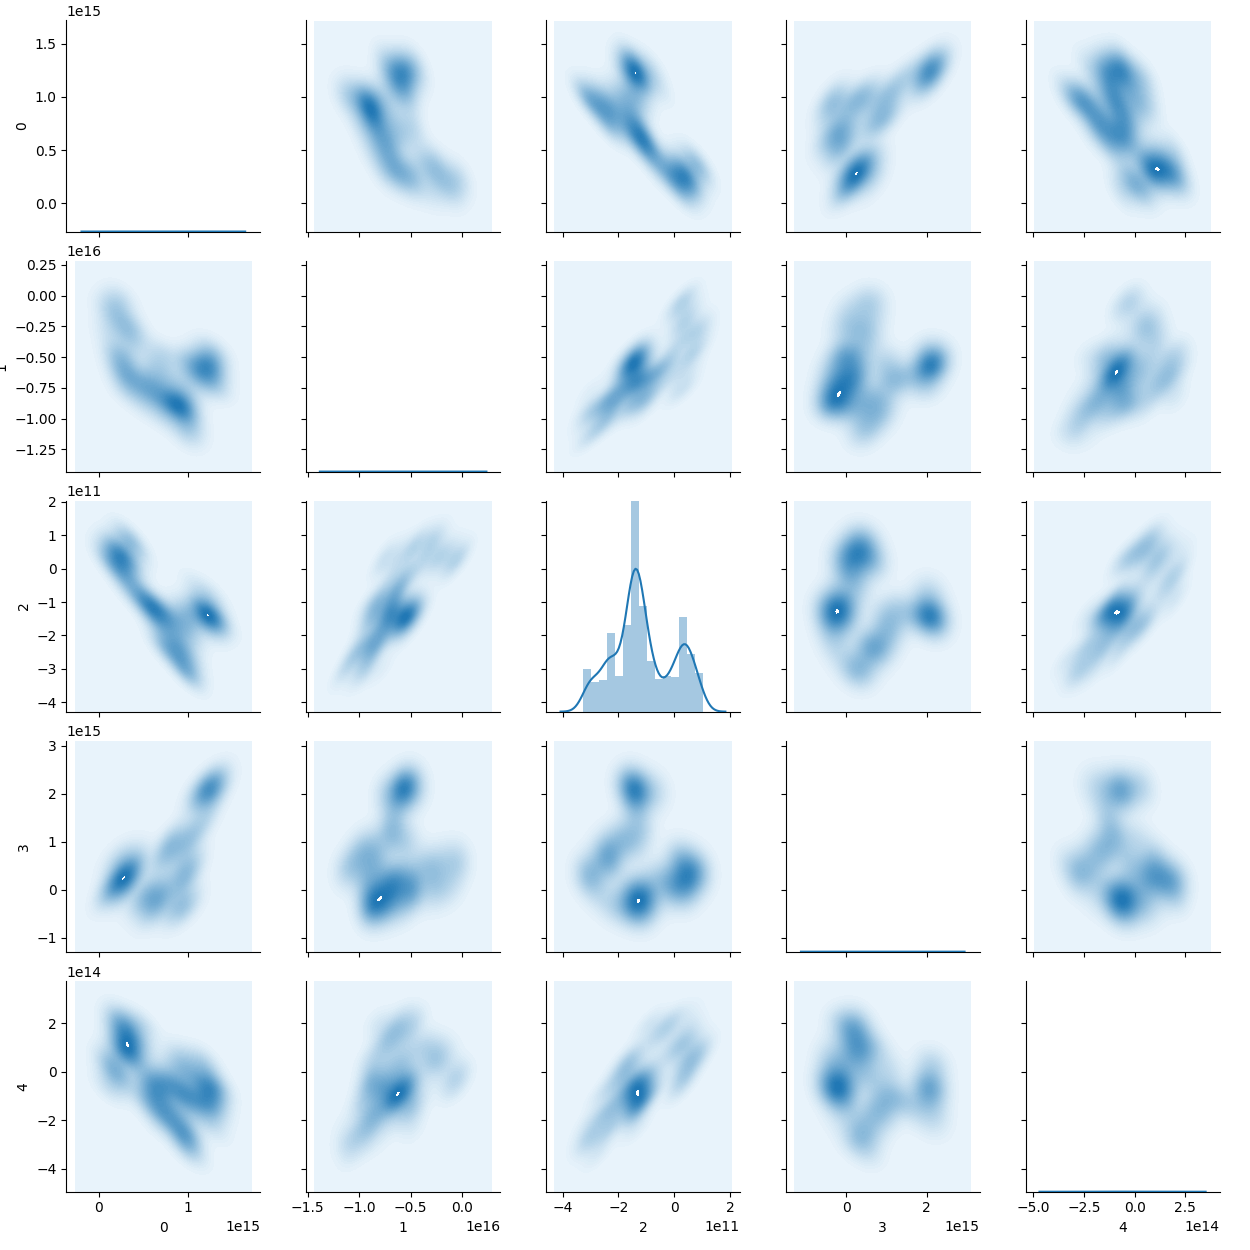

/net/theorie/home/tjansse2/studium/masterarbeit/hep-monte-carlo/hepmc_env/lib64/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [63]:
g = sns.PairGrid(df)
#g.map(sns.kdeplot)
g.map_upper(sns.kdeplot, n_levels=60, shade=True)
g.map_lower(sns.kdeplot, n_levels=60, shade=True)
g.map_diag(sns.distplot)
plt.show()

In [ ]:
#x = np.array(list(product(np.linspace(.001, .999, 10), repeat=5)))

plt.figure()
#plt.subplot(121)
#plt.imshow(basis.eval_split(*params, *mgrid))
plt.subplot(122)
plt.imshow(-np.log(mapped.pdf(*mgrid)))
plt.show()

In [ ]:
start = np.array([0.30527385, 0.59699739, 0.51985594, 0.57366659, 0.51096818])
sampler = hamiltonian.StaticSphericalHMC(mapped, .03, .03, 30, 30)
hmc_sample = sampler.sample(50000, start)